<a href="https://colab.research.google.com/github/SimonAndren/CS166/blob/main/Traffic_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pseudocode

Thiis Pseudocode is included

In [1]:
# Section 1 [PseudoCode]:

class TrafficSimulator_pseudo:
    """This class implement the traffic simulator
    
    The road section has one main road - Sockenvägen. The traffic enters sockenvägen from six roads, and leaves from equall many
    Sockenvägen has classic 4 way intersection with traffic lights and 1 cross-road. There are also two additional cross-roads,
    one at Gamla Tyresövägen and one at kärrtorps vägen. 
    
    The simulation will update with a timestep equal to 3.6 seconds. Each grid cell corresponds to a 5x5 meter cell. 
    The distance of sockenvägen for our simulation is approximatly 500 m."""
    
    def __init__(self):
        self.curr_grid = self.initialize()
        self.next_grid = self.curr_grid
        self.time = 3.6 #each update correspond to 3.6 second. At 10 km/h, you do 10 m in 3.6 second
        self.current_time = 0 #start of the simulation
        self.max_v = 5 #max velocity = 50 km/h
        self.grid_length = 10 #10 m per grid
        
    def initialize(self):
        #This method initialize an empty section of the street with no cars
        #".'s are empty, "-" lane boarders, "x" are closed road (crosswalk or traffic light) "0,1,2,3,4,5" = speed of car
        pass
        
    def observe(self):
        #This method observes the current grid and print out the current grid
        pass
        
    def update_traffic_light(self):
        #This method updates the traffic lights and cross walks
        pass
        
    def update_RL_turn(self):
        #This method updates the right and left turns
        pass
        
    def update_single_lane(self):
        #This method updates all the single lanes using simple acceleration and deacceleration
        pass
        
    def update_new_cars(self):
        #This method adds new cars where cars can enter
        pass
    


# Final revision

The following cells contain the Grid-Based simulation code associated with the CS166 LBA. The simulation within one class names - Trafficsimulation.

The class's attributes holds information about the update-rules for the intersection, the location or the intersection, current traffic information, state of the simulation and many more.

I decided to implement the simulation using one single class, containing information and methods for the intersection as well as the car. This is because I didn't deem it necissary to build two seperate classes, one for the intersection and one for the cars. The cars are very basic only containing a velocity. The history for each car is unnecissary given the problem scope. Instead I utilized integeres that represent cars and their velocities. This will be explain in more detail now.

The grid represents the intersection between Gamla Tyresövägen and Sockenvägen. The grid is a 40x40 matrix and each entry is the spatial information for the location. Each cell represent a 5x5 m square. "." is an empty cell, "|" or "-" is road edges, "x' is lane block (red light or cross-walk), and integers above 0 to 5 is cars and their velocities. 

Each simulation update corresponds to 1.8 s. In this time, the cars will have moved equally many cells as their velocities. The cross-walk and traffic light is updated according to their rules but this update time is taking into consideration.

The arrival rates for the roads are normalized to 1.8 s from the original observed rates for 3 minutes. To normalize the original rates (180 s) the original rates are divided by 100 (180/1.8). The arrival of cars are drawn from a exponential distribution. This is since the arrival of cars is assumed to be a poisson processes. The arrival of a car doesn't contain any information about when the next arrival will be. Because of this memory-less property, we can sample from a exponential distribution each update and if it's below 1, then we can say that a car has arrived, else, no car arrived and we sample again next update. Since no 5x5 can't be occupied by more than 1 car, only 1 car can arrive each update.

Detailed information about methods and attributes are explained throughout the code


In [2]:
#Import all relevent packages
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
class Trafficsimulation:
  """This class implement the traffic simulation for the intersection between sockenvägen and Gamla Tyresövägen (GTV).
  
  Traffic enters and exit in 4 locations , west and east on sockenvägen and north and south on GTV. 
  All traffic going east are located on a even number row and west on a odd numbered row. This corresponds to the right of way rule.
  Traffic going north are located on even number columns and south on odd numbered column.
  
  The two most heavy trafficed roads are east and bound on sockenvägen and north-bound on GTV.
  The traffic is implemented in a 40x40 grid where each cell is a 5x5m square. 
  
  -----------------------
  The attributes are the following

  roads_dict : dictionary containing lists
    lists for the dimensions for each of the roads [row_start, row_end, col_start, col_end]
  car_interval : dictionary containing lists
    list of the arrival rate in each of the directions [N/E, S/W]
  traffic_blocks : dictionary containing lists
    List of update-rule and current state for  traffic light
  rush : float
    Multiplicator for traffic rush compared to the data gathered
  prob_slow : float
    Probability of randomly slowing down
  curr_grid : 40x40 matrix
    Matrix of the current state of the road section
  next_grid : 40x40 matrix
    Matrix of the next state of the road after update.
  time : float
    Time per update (s)
  curr_time : float
    Current time for the simulations (s)
  max_v : float
    Maximum velocity for each car
  leave : int
    Number of cars that have left the section
  enter : int
    Number of cars that have entered the section
  queue_length_sock : matrix
    Matrix of the queue length in each direction at sockenvägen when light turn green
  queue_length_GTV : matrix
    Matrix of the queue length in each direction at GTV when light turn green
"""

  def __init__(self, light_freq = 60, rush = 1, prob_slow = 0.3, queue_switch = 10):
      self.roads_dict = {
          "sock_road": [19,20,0,39],
          "GTV": [0,39,19,20]}
      self.car_interval = {
          "sock_road": [24/100, 17/100], #Even road (N/E) then Odd road (S/W)
          "GTV": [20/100, 14/100]}
      self.traffic_lights = {
          "intersect": [light_freq, None, 0, queue_switch]} #Seconds between switch, lane that is blocked (S = sock and G = GTV), updates to switch, len at switch
      self.rush = rush
      self.prob_slow = prob_slow
      self.curr_grid = self.initialize()
      self.next_grid = self.curr_grid.copy()
      self.time = 1.8 #each update correspond to 1.8 second. At 10 km/h, you do 5 m in 1.8 second
      self.curr_time = 0 #Start of the simulation
      self.max_v = 5 #max velocity = 50 km/h
      self.queue_length_sock = []
      self.queue_length_GTV = []
      self.enter = 0
      self.leave = 0
      self.turns = 0

  def initialize(self):
      """This method initialize an empty section of the street with no cars.
      "."s are empty, "-" and "|" lane borders, "x" are closed road (crosswalk or traffic light) "0,1,2,3,4,5" = speed of 
      The roads are list of start and finish of the roads. the first 2 are index for the start and end in the rows
      The last two index are start and end for the columns
      """
      #initialize a empty 40x40 grid
      grid = np.tile(["."], (40,40))

      #dtype object so it can hold integers and strings
      grid = np.array(grid, dtype=object)
      
      #build the horizonal road (sockenvägen)
      for row in (self.roads_dict["sock_road"][0]-1, self.roads_dict["sock_road"][1]+1):#The N-S borders for the road

          for col in range(self.roads_dict["sock_road"][2], self.roads_dict["sock_road"][3]+1): #The W-E borders of the road

              grid[row, col] = "-" #border
      
      #Build the vertical road (GTV)        
      for row in range(self.roads_dict["GTV"][0], self.roads_dict["GTV"][1]+1):
          
          #The W-E borders for the road
          for col in (self.roads_dict["GTV"][2]-1, self.roads_dict["GTV"][3]+1):
              
              #Remove borders (add intersection) between road and sockenvägen
              if row == 18 or row == 21:
                  grid[row, self.roads_dict["GTV"][2]+1] = "."
                  grid[row, self.roads_dict["GTV"][3]-1] = "."
              
              #Add borders
              elif row != 19 and row != 20:
                  grid[row, col] = "|"
      return grid

  def observe(self):
      """This method observes the current grid and print out the current grid as a imshow"""
      
      #Change all special characters to numerical values
      print_array = np.where(self.curr_grid=="-", -2, self.curr_grid) 
      print_array = np.where(print_array=="|", -2, print_array) 
      print_array = np.where(print_array==".", -1, print_array)
      print_array = np.where(print_array=="x", -3, print_array)

      #Change datatype to float
      print_array = print_array.astype(np.float)
      #all the unique values in the data
      values = np.unique(print_array.ravel())

      #Include only car velocities
      values = values[np.array(values >= 0)]

      #Image of the intersection
      im = plt.imshow(print_array)
      
      #reference - https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib

      #find the colors of the values for the imshow
      colors = [ im.cmap(im.norm(value)) for value in values]
      # create a patch (proxy artist) for every color 
      patches = [ mpatches.Patch(color=colors[i], label="Velocity {l} (10 km/h)".format(l=values[i]) ) for i in range(len(values)) ]
      # put those patched as legend-handles into the legend
      plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

      plt.show()
  
  def cars_in_traffic(self):
      """This method computes the total number of active cars in the grid, by counting the number of integers on the grid"""
      count = 0 #count variable
      
      #loop through each position
      for row in range(sim.curr_grid.shape[0]):
        for col in range(sim.curr_grid.shape[1]):
          if type(sim.curr_grid[row,col]) == int: #if the cell is a car
            count += 1 

      return count

  def count_red_queue(self, road):
      """This method computes the queue length in each direction along a road from the traffic light.
      It computes the road length for the given road by counting the number of 
      consequtive integers from the traffic light in the appropriate direction"""
      queue_count_SE = 0
      queue_count_NW = 0
      if road == "sock": #if sockenvägen is closed 
        for i in range(2): #For each direction along sockenvägen
          lane = self.roads_dict["sock_road"][i] #The lane to check queue length for
          for col in range(self.roads_dict["GTV"][3-i]+2-i*4,self.roads_dict["sock_road"][3-i]+1-i*2, 1-2*i): #loop each column in the direction of traffic
            if type(self.curr_grid[lane, col]) == int: #if it is a car, add to counter for the direction
              if i == 0:
                queue_count_NW += 1
              else:
                queue_count_SE += 1
            else:
              break
      elif road == "GTV": #GTV is closed
        for i in range (2): #for each direction along GTV
          lane = self.roads_dict["GTV"][i+2] #The lane to check queue length for
          for row in range(self.roads_dict["sock_road"][i]-2+i*4, self.roads_dict["GTV"][i]-1+i*2, -1+2*i): #Loop through each row in direction of traffic
            if type(self.curr_grid[row, lane]) == int:
              if i == 0:
                queue_count_NW += 1
              else:
                queue_count_SE += 1
            else:
              break
      

      return (queue_count_NW, queue_count_SE)

  def update_new_cars(self):
      """This method adds car to the entrences of the road section from a exponential distribution
      
      To decide whether a car arrives, we sample from a expontial distribution with the appropriate arrival rate.
      If less than 1, a car has arrived and a maximum of 1 car can arrive each update."""
      
      for i in range(2): #Add for each entrence in W/E directions (sockenvägen)
        
        #Sample the next arrival.
        arr_time_sock = sts.expon(scale = 1/(self.car_interval["sock_road"][i]*self.rush)).rvs() 
        
        if arr_time_sock < 1: #If the next car arrives within 1 (3.6 second)

          #if the arrival slot is empty
          if self.curr_grid[self.roads_dict["sock_road"][1-i], self.roads_dict["sock_road"][2+i]] == ".":
            #car arrives with a speed of 50 km/h
            self.next_grid[self.roads_dict["sock_road"][1-i], self.roads_dict["sock_road"][2+i]] = self.max_v
            self.enter += 1

      for i in range(2): #Loop for each entrence in N/S (GTC)
        
        #Sample the next arrival.
        arr_time = sts.expon(scale = 1/(self.car_interval["GTV"][i]*self.rush)).rvs()

        if arr_time < 1: #If the car arrived within 1 (1.8 s)

          #If the next grid is empty
          if self.curr_grid[self.roads_dict["GTV"][1-i], self.roads_dict["GTV"][3-i]] == ".":
            #car arrives with a speed of 50 km/h
            self.next_grid[self.roads_dict["GTV"][1-i], self.roads_dict["GTV"][3-i]] = self.max_v
            self.enter += 1

  def update_road_blocks(self, strategy = "fixed"):
      """This method update the traffic light as the intersection and the cross walk at sockenvägen"""
      
      if strategy == "fixed": #if the traffic light has the fixed strategy
        #if the remainder of the current time divided by the frequency of switch is odd or even, switch red-green light
        if self.traffic_lights["intersect"][2] == 0: #If it's time to switch
          
          if self.curr_grid[18,19] == "x" or self.curr_time == 0: #Close sockenvägen and open GTV
            self.next_grid[20,18] = "x"
            self.next_grid[19,21] = "x"
            self.next_grid[18,19] = "."
            self.next_grid[21,20] = "."
            self.traffic_lights["intersect"][1] = "S"
            
            if self.curr_time > 0: #append the queue length at GTV
              self.queue_length_GTV.append(self.count_red_queue(road = "GTV"))

          else: #Close GTV and open sockenvägen
            self.next_grid[20,18] = "."
            self.next_grid[19,21] = "."
            self.next_grid[18,19] = "x"
            self.next_grid[21,20] = "x"
            self.traffic_lights["intersect"][1] = "G"
            
            if self.curr_time > 0: #Append the queue length at sockenvägen
              self.queue_length_sock.append(self.count_red_queue(road = "sock"))            

          #Update the number of updates to next switch (remainder of time in second between switches and update time)
          self.traffic_lights["intersect"][2] = self.traffic_lights["intersect"][0]//self.time
        
        else:
          self.traffic_lights["intersect"][2] += -1 #Decrease updates to switch
      
      else: #use the deterministic strategy to switch traffic light
        if self.curr_time == 0: #start by closing sockenvägen
            self.next_grid[20,18] = "x"
            self.next_grid[19,21] = "x"
            self.next_grid[18,19] = "."
            self.next_grid[21,20] = "."
            self.traffic_lights["intersect"][1] = "S"
        
        elif self.traffic_lights["intersect"][1] == "S": #if sockenvägen is closed
          queue_len = self.count_red_queue("sock") #get the queue length for sockenvägen

           #if any queue is greater or equal to 10 in length, open Sock and close GTV
          if queue_len[0] >= self.traffic_lights["intersect"][3] or queue_len[1] >= self.traffic_lights["intersect"][3]:
            self.next_grid[20,18] = "."
            self.next_grid[19,21] = "."
            self.next_grid[18,19] = "x"
            self.next_grid[21,20] = "x"
            self.traffic_lights["intersect"][1] = "G"
        
        else: #If GTV is closed
          queue_len = self.count_red_queue("GTV")

          #if any queue is greater or equal to 10 in length, open GTV and close Sock
          if queue_len[0] >= self.traffic_lights["intersect"][3] or queue_len[1] >= self.traffic_lights["intersect"][3]: 
            self.next_grid[20,18] = "x"
            self.next_grid[19,21] = "x"
            self.next_grid[18,19] = "."
            self.next_grid[21,20] = "."
            self.traffic_lights["intersect"][1] = "S"

  def update_RL_turn(self, row, col, direction):
      """this method updates the cars position if turning left of right in the intersection.
      If car turns, place them at the beginning of lane turning to with current speed"""
      self.turns += 1

      if direction == "WE":
        
        #80% chance of going north
        if np.random.random() < 0.7:
          self.next_grid[17,20] = self.next_grid[row,col]
          self.next_grid[row,col] = "."
          #print(f"Turn = {(row, col)} north")
        else: #else going south
          self.next_grid[22,19] = self.next_grid[row,col]
          self.next_grid[row,col] = "."
          #print(f"Turn = {(row, col)} south")
      
      else:
        #80% chance of going west
        if np.random.random() < 0.7:
          self.next_grid[19,17] = self.next_grid[row,col]
          self.next_grid[row,col] = "."
          #print(f"Turn = {(row, col)} west")
        else: #else going east
          self.next_grid[20,22] = self.next_grid[row,col]
          self.next_grid[row,col] = "."
          #print(f"Turn = {(row, col)} east")

  def update_NWES(self, row, col, direction):
      """This method update cars position and velocity continuing their original direction."""
      #If the car is at exit position, remove it
      if (row == 19 and col == 0) or (row == 20 and col == 39) or (row == 0 and col == 20) or (row == 39 and col == 19):
        self.next_grid[row, col] = "." #Remove the car
        self.leave += 1
      
      #Direction is negative if west/north going and positive if east/south going
      else:
        if direction == "E" or direction == "S":
          direct = 1 #moving in positive direction on the grid
        else: 
          direct = -1 #moving in negative direction on the grid
      
        #Distance to car if car are moving on sockenvägen
        if direction == "E" or direction == "W":
          dist_to_car_x = direct
          dist_to_car_y = 0

          #Compute the distance to next car
          while col+dist_to_car_x <= 39 and col+dist_to_car_x >= 0: 

            #if the cell infront is empty
            if self.curr_grid[row, col+dist_to_car_x] == ".":
              if col+dist_to_car_x != 18 or col+dist_to_car_x != 21: #don't count the red_light cell
                dist_to_car_x += direct #add to the distance
            else:
              break #Break while loop

        else: #if the car is moving on GTV
          dist_to_car_x = 0
          dist_to_car_y = direct

          #Compute the distance to next car
          while row+dist_to_car_y <= 39 and row+dist_to_car_y >= 0: 

            #if the cell infront is empty
            if self.curr_grid[row+dist_to_car_y, col] == ".":
              if row+dist_to_car_y != 18 or row+dist_to_car_y != 21: #don't count the traffic light cell
                dist_to_car_y += direct #add to the distance
            else:
              break #Break while loop

        #Accelerate by 1 if speed is less than max speed
        if self.curr_grid[row, col] < self.max_v:
          self.curr_grid[row, col] += 1
        
        #If the speed is more than the distance to car infront, slow down
        if self.curr_grid[row, col] >= max(abs(dist_to_car_x),abs(dist_to_car_y)):
          self.curr_grid[row, col] = max(abs(dist_to_car_x),abs(dist_to_car_y))-1
        
        #random slowing if car is moving
        if self.curr_grid[row, col] > 0 and np.random.random() < self.prob_slow:
          self.curr_grid[row, col] += -1

        #Compute the new vector V (- or +) 
        v =  direct * self.curr_grid[row, col]

        if col+v > 39 or col+v < 0 or row+v > 39 or row+v < 0: #Car's new position is outside the grid, remove it

          self.next_grid[row, col] == "."
          self.leave += 1

        else: #remove the old position and add the new position
          self.next_grid[row, col] = "."
          add_v = 0 #correction for traffic light

          if direction == "E" or direction == "W": #If moving on sockenvägen, update the column

            if col+v == 18 or col + v == 21: #If car would end up on the traffic light
              
              if direction == "E": #if moving east, add -1 to the x_position
                add_v = -1
              else: #Moving west, add 1 to the x_position
                add_v = 1

            self.next_grid[row, col+v + add_v] = abs(v) #update the postion for the car and it's current speed
          
          else:  #If moving on sockenvägen, update the row
            if row + v == 18 or row + v == 21: #If car would end up the traffic light
              if direction == "S": #If moving south add -1 to row/y-position
                add_v = -1
              else:
                add_v = 1
            self.next_grid[row+v+add_v, col] = abs(v) #update position for the car and it's current speed

  def update_cars(self):
      """This method updates the position of the cars on both GTV and Sockenvägen.
      The next position of a car is computed from the current speed and position.
      
      If the car is within reach of turning, there is a 50% chance of turning. 
      Else the cars next position will be it's velocity addedd to the current location. 
      I.e. A east bound car with velocity 5 at column position 10, will end up at 15 after being updated"""

      #Don't update the lanes within the intersection if road has a red light
      intersection_sock = [19,20] #Positions to skip if sockenvägen is blocked
      intersection_GTV = [19,20] #Positions to skip if GTV is blocked

      #Update for sockenvägen
      for i in range(2): #For each lane

        #lane to update
        lane = self.roads_dict["sock_road"][i]

        #Columns to update
        cols = [i for i in range(40)]

        #If the traffic light is on for sockenvägen, don't update any columns in the intersection
        if self.traffic_lights["intersect"][1] == "S":
          cols = np.delete(np.array(cols), np.array(intersection_sock))

        for col in cols: #for each column

          if type(self.curr_grid[lane,col]) == int: #If the cell contains a car

            if i == 0: #if the cell is west going
              #if the cell is within range of turning and the traffic light is green, there is a 50% change of turning
              #The car can turn if the current position + it's velocity is within range for GTV 
              if (col >= 20 and col - self.curr_grid[lane, col] <= 20 and            #if the car is in a spot and with the required speed to turn
                  self.curr_grid[17,20] == "." and self.curr_grid[22,19] == "." and  #and the car can turn in both directions
                  self.next_grid[17,20] == "." and self.next_grid[22,19] == "." and  #and future car has turn in either direction
                  self.traffic_lights["intersect"][1] == "G" and                     #and there is green light
                  np.random.random() < 0.5):                                         #There is a 50% change of turning
                self.update_RL_turn(lane, col, direction = "WE") #turn the car left or right

              else:
                self.update_NWES(lane, col, "W") #Continue west
            
            else: #The car is east going
              #Similar if statement as for cars going west
              if (col <= 19 and col + self.curr_grid[lane, col] >= 19 and 
                  self.curr_grid[17,20] == "." and self.curr_grid[22,19] == "." and  
                  self.next_grid[17,20] == "." and self.next_grid[22,19] == "." and
                  self.traffic_lights["intersect"][1] == "G" and                  
                  np.random.random() < 0.5): 
                self.update_RL_turn(lane, col, "WE") #Turn car to left or right

              else:
                self.update_NWES(lane, col, "E")
      
      #Update for GTV
      for i in range(2,4): #1 for each lane

        lane = self.roads_dict["GTV"][i]

        #rows to update
        rows = [i for i in range(40)]

        #If the traffic light is on for sockenvägen, don't update any columns in the intersection
        if self.traffic_lights["intersect"][1] == "G":
          rows = np.delete(np.array(rows), np.array(intersection_GTV))

        for row in rows: #for each row
          if type(self.curr_grid[row,lane]) == int: #if cell is a car

            if i == 2: #If the car is going in the south direction
              if (row <= 19 and row + self.curr_grid[row,lane] >= 19 and            #if the car is in a spot and velocity to turn
                  self.curr_grid[19,17] == "." and self.curr_grid[20,22] == "." and #if the car can turn is both direction
                  self.next_grid[19,17] == "." and self.next_grid[20,22] == "." and #if not car has already turned in both direction
                  self.traffic_lights["intersect"][1] == "S"                        #if it's green light
                  and np.random.random() < 0.5):                                     #50% chance of turning
                self.update_RL_turn(row, lane, "NS") #Turn car to left or right

              else:
                self.update_NWES(row, lane, "S")
            
            else:
              #Similar if statement as for cars going south
              if (row >= 20 and row - self.curr_grid[row,lane] <= 20 and 
                  self.curr_grid[19,17] == "." and self.curr_grid[20,22] == "." and 
                  self.next_grid[19,17] == "." and self.next_grid[20,22] == "." and
                  self.traffic_lights["intersect"][1] == "S"                        
                  and np.random.random() < 0.5):
                self.update_RL_turn(row, lane, "NS") #Turn car to left or right

              else:
                self.update_NWES(row, lane, "N")  


  def update(self, update_arrival = True, update_light_cross = True, update_traffic = True, strategy = "fixed"):
      
      #Make a copy for the next grid
      self.next_grid = self.curr_grid.copy()

      #update arrivals
      if update_arrival:
        self.update_new_cars()

      #Update cross lights
      if update_light_cross:
        self.update_road_blocks(strategy)
        self.curr_grid = self.next_grid.copy()
        self.next_grid = self.curr_grid.copy()
      
      #Update the traffic
      if update_traffic:
        self.update_cars()

      self.curr_time += self.time #update the current time and save the new grid
      self.curr_grid = self.next_grid.copy()

The simulation is now complete. We will test that the code work by checking that

1.   The number of cars entering the section under a certain time interval is the same as the nuumber of cars leaving the section (together with the all cars currently in the section) during the time-period. This checks that no cars magically disapears.
2.   50% of all cars make a left-right turn. This verifies that the turning rules for the car works.

In [4]:
#lists to hold the data
turn_fraction = []
section_history = []


for i in range(100): #do 100 simulations
  sim = Trafficsimulation() #Use the fixed traffic light strategy
  for j in range(250): #simulate 15 minutes of traffic 
    sim.update() 
  turn_fraction.append(sim.turns/sim.leave) #append the fraction of cars turning
  section_history.append([sim.enter, sim.leave+sim.cars_in_traffic()]) #append the history for cars entering, and leaving + currently in the simulation

turn_mean = np.mean(np.array(turn_fraction))
turn_conf = np.percentile(np.array(turn_fraction), [2.5, 97.5])

section_diff = np.unique(np.array([run[1]-run[0] for run in section_history]))

print(f"On average, {turn_mean} or the cars leaving the road section turned once")
print(f"In 95% of the simulation, the fraction of cars turning was between {turn_conf[0]} and {turn_conf[1]} \n")

print(f"The difference between cars entering the road section, and leaving the road section/currently in the road section for each simulation is always {section_diff}")

On average, 0.42827674849011493 or the cars leaving the road section turned once
In 95% of the simulation, the fraction of cars turning was between 0.36714931767692793 and 0.4903820895522388 

The difference between cars entering the road section, and leaving the road section/currently in the road section for each simulation is always [0]


From these results, I can with a high confidence say that it appears that the code works the way it should to. Equally many cars enter the road section and cars leaving the road section or being currently in the road section.

To qualitativly evaluate the simulation, we could also print out the 20 first states of the road section to see how it's being updated.

0 - Update


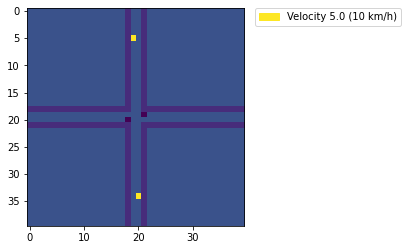

1 - Update


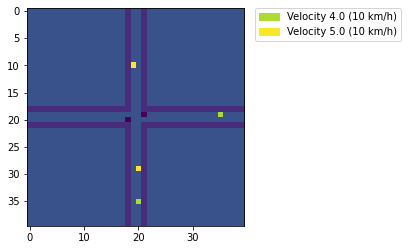

2 - Update


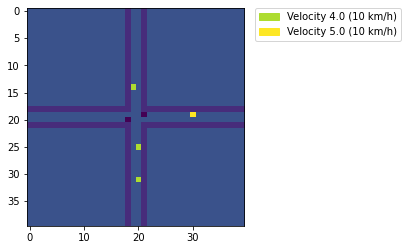

3 - Update


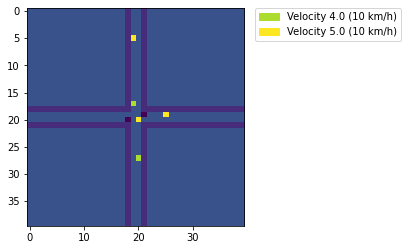

4 - Update


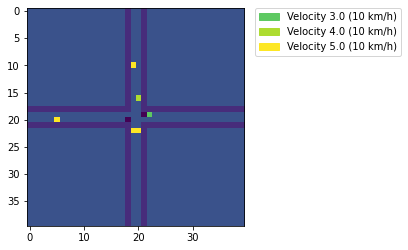

5 - Update


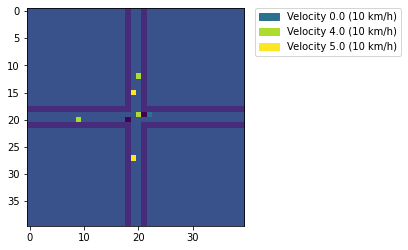

6 - Update


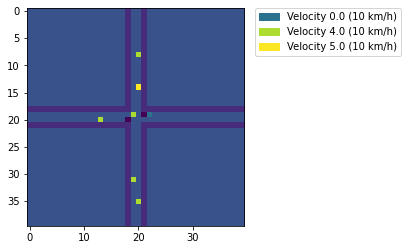

7 - Update


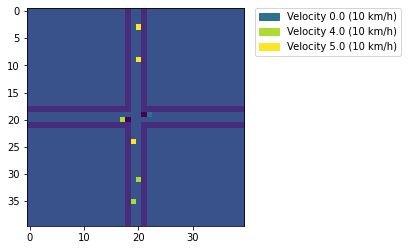

8 - Update


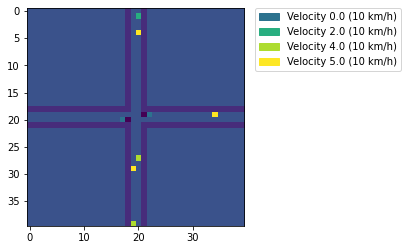

9 - Update


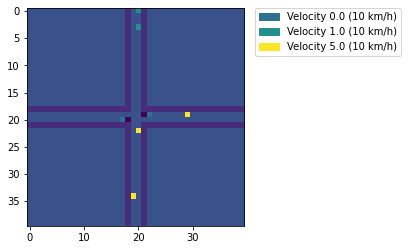

10 - Update


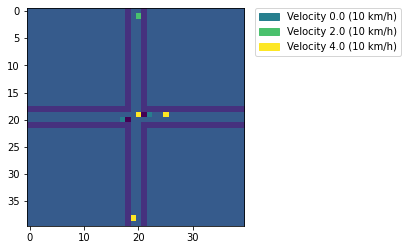

11 - Update


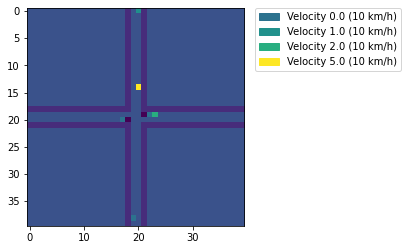

12 - Update


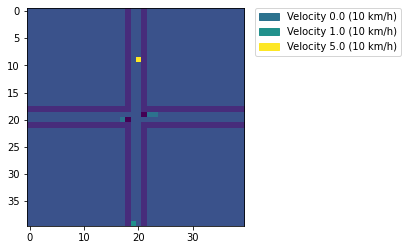

13 - Update


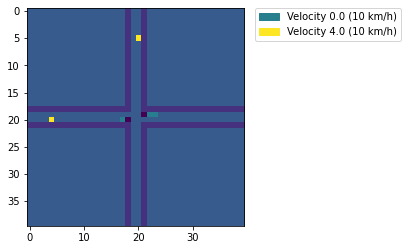

14 - Update


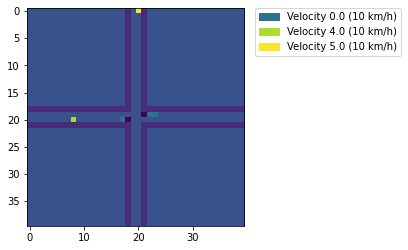

15 - Update


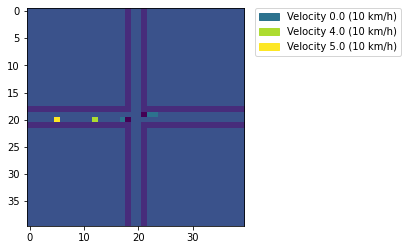

16 - Update


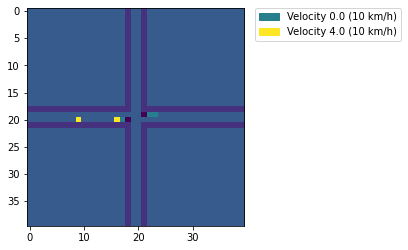

17 - Update


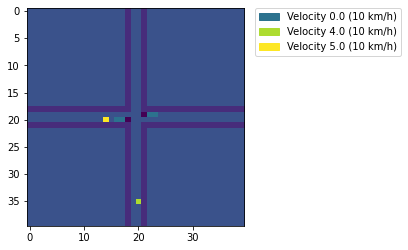

18 - Update


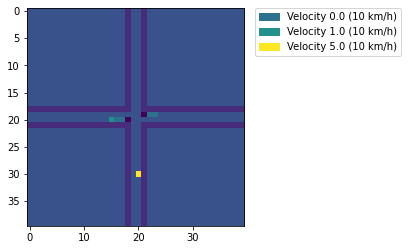

19 - Update


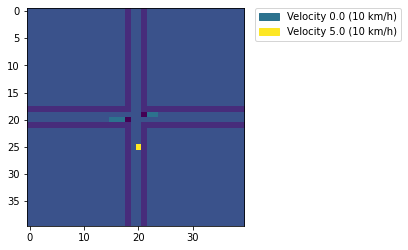

In [5]:
sim = Trafficsimulation()
for i in range(20):
  sim.update()
  print(f"{i} - Update")
  sim.observe()

# Experiments and empirical results

First, the behavior of the intersection will be evaluate using the fixed switch rate, with the observed switch rate of around 1 minutes. The behavior will be studied under different arrival rates. The measured quantities will be (1) Average queue length at traffic light before switch (2) Section capacity (cars leaving the road section in a time interval).

The first strategy (fixed switch rate) will first be evaluated to find the optimal switch rate. The capacity and the queue length for different switch rates, at different densities (0.5, 1, and 1.5 of the usual) will be compared. Three switch rates will be compared, one where it which every 30, every 60, and every 90 second. The optimal strategy will allow for many passing cars and minimal queue length. 

The second strategy (deterministic) will be evaluated using similar quantities. The capacity will be studied for different densities. The rule for switching will be after queue length of 3, 6, and 10 cars. The optimal strategy for each density is the strategy that allows for the highest number of passing cars. 

The optimal strategy for each density will then be compared against each other and inference about the optimal strategy will be drawn.



In [6]:
#experiment 1

densities = [0.5, 1, 1.5]
switch_rates = [30, 60, 90]

summary_queue_data = []
summary_capacity_data = []

for density in densities: #for each arrival rate/density
  
  switch_average_queue = [] #for each density/arrival rate
  switch_section_history = [] #for each densty/arrival rate

  for switch_rate in switch_rates: #for each time between switching
    
    average_queues = [] #for each density and rate, build a summary list
    section_history = [] #for each density and rate, build a summary list

    for i in range(100): #Simulations to run
      
      sim = Trafficsimulation(light_freq = switch_rate, rush = density) #create a simulation

      for j in range(250): #run for 7.5 minutes
        sim.update(strategy="fixed")
      
      queue_datum_sock_W = np.array([datum[0] for datum in sim.queue_length_sock]) #queue in west direction
      queue_datum_sock_E = np.array([datum[1] for datum in sim.queue_length_sock]) #queue in east direction
      queue_datum_GTV_N = np.array([datum[0] for datum in sim.queue_length_GTV]) #queue in north direction
      queue_datum_GTV_S = np.array([datum[1] for datum in sim.queue_length_GTV]) #queue in south direction

      #summary data for the queue length
      queue_data = np.concatenate((queue_datum_sock_W, queue_datum_sock_E, queue_datum_GTV_N, queue_datum_GTV_S))

      #append values to data summaries
      average_queues.append(np.mean(queue_data))
      section_history.append(sim.leave)
    
    #convert to numpy arrays
    average_queues = np.array(average_queues) 
    section_history = np.array(section_history) 

    #append to the density list
    switch_average_queue.append([np.mean(average_queues), np.percentile(average_queues, 2.5), np.percentile(average_queues, 97.5)])
    switch_section_history.append([np.mean(section_history), np.percentile(section_history, 2.5), np.percentile(section_history, 97.5)])
  
  summary_queue_data.append(switch_average_queue) #append to the summary data
  summary_capacity_data.append(switch_section_history) #append to the summary data

summary_queue_data = np.array(summary_queue_data)
summary_capacity_data = np.array(summary_capacity_data)

In [7]:
queue_data

array([ 7,  8, 15, 18, 12, 11, 15, 17])

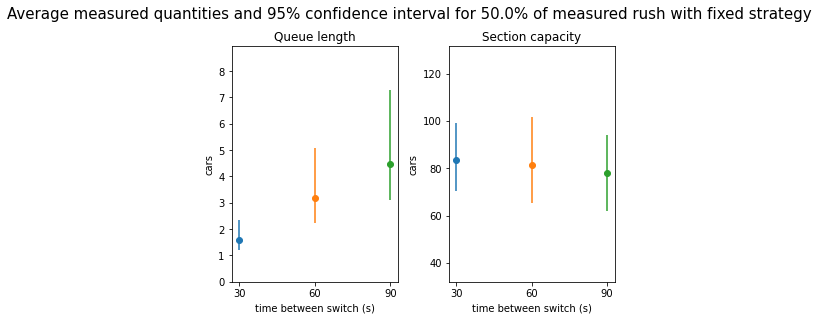

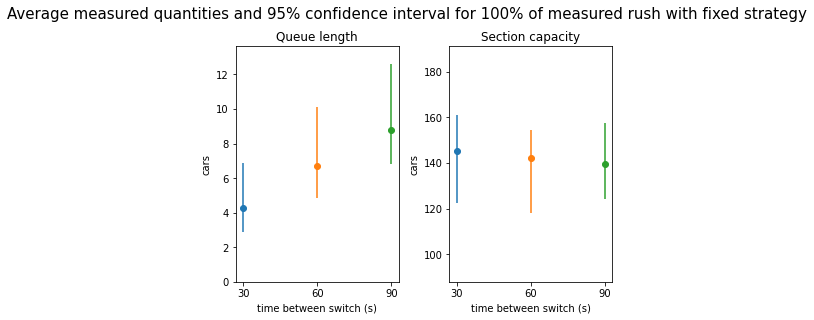

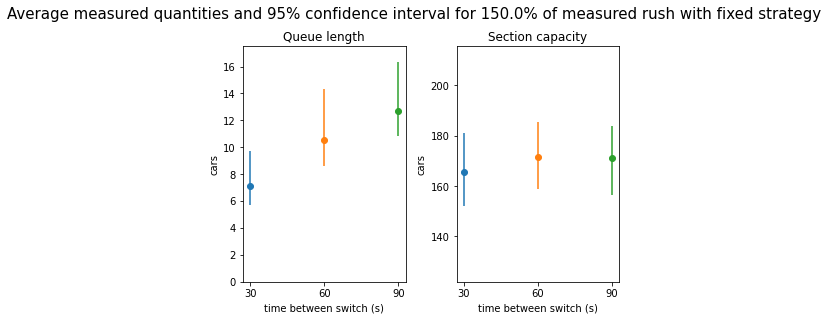

In [8]:
#plot the queue length data per strategy

#loop one time for each arrival rate
for i in range(3):

  fig, ax = plt.subplots(nrows = 1, ncols = 2)#create two subplits

  for j in range(3): #loop through each switch strategy

    #plot the error bars for each quantity
    ax[0].errorbar(switch_rates[j], summary_queue_data[i,j][0], fmt='-o',
                   yerr = [[summary_queue_data[i,j][0]-summary_queue_data[i,j][1]], [summary_queue_data[i,j][2]-summary_queue_data[i,j][1]]])
    ax[1].errorbar(switch_rates[j], summary_capacity_data[i,j][0], fmt='-o',
                   yerr = [[summary_capacity_data[i,j][0]-summary_capacity_data[i,j][1]], [summary_capacity_data[i,j][2]-summary_capacity_data[i,j][0]]])
    
  #set the x ticks
  plt.setp(ax, xticks=switch_rates)

  #set ylimit
  ax[0].set_ylim([0,np.max(summary_queue_data[i])+3])
  ax[1].set_ylim([np.min(summary_capacity_data[i])-30,np.max(summary_capacity_data[i])+30])

  #set labels
  ax[0].set_xlabel("time between switch (s)")
  ax[0].set_ylabel("cars")

  #set labels
  ax[1].set_xlabel("time between switch (s)")
  ax[1].set_ylabel("cars")

  #the layout
  fig.tight_layout()

  #titles
  ax[0].title.set_text('Queue length')
  ax[1].title.set_text('Section capacity')
  fig.suptitle(f"Average measured quantities and 95% confidence interval for {100*densities[i]}% of measured rush with fixed strategy", 
                 fontsize=15, verticalalignment = "top", y = 1.1)



In [9]:
#experiment 2

densities = [0.5, 1, 1.5]
switch_len = [3, 6, 10]

summary_capacity_data = []

for density in densities: #for each arrival rate/density
  
  switch_section_history = [] #for each densty/arrival rate

  for switch in switch_len: #for each time between switching
    
    section_history = [] #for each density and rate, build a summary list

    for i in range(100): #Simulations to run
      
      sim = Trafficsimulation(rush = density, queue_switch = switch) #create a simulation

      for j in range(250): #run for 7.5 minutes
        sim.update(strategy="deterministic")
      
      #append values to data summaries
      section_history.append(sim.leave)
    
    #convert to numpy arrays
    section_history = np.array(section_history) 

    #append to the density list
    switch_section_history.append([np.mean(section_history), np.percentile(section_history, 2.5), np.percentile(section_history, 97.5)])
  
  summary_capacity_data.append(switch_section_history) #append to the summary data

summary_capacity_data = np.array(summary_capacity_data)

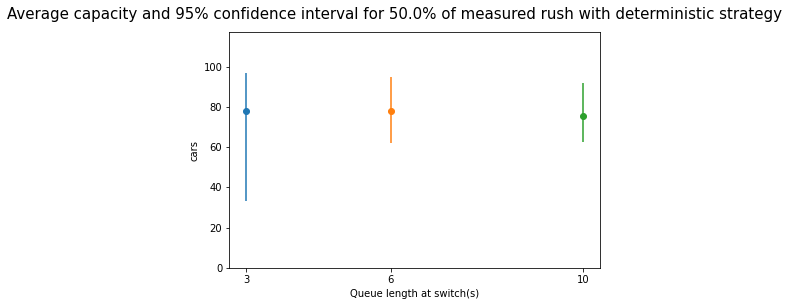

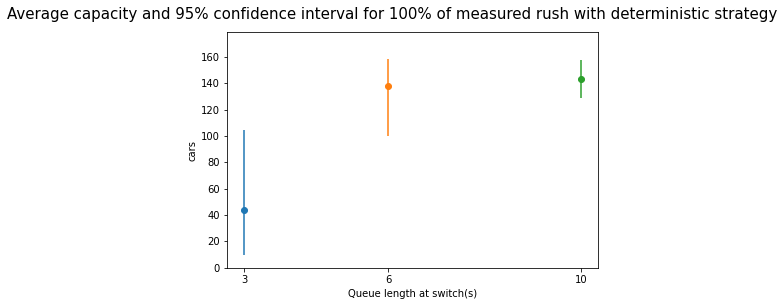

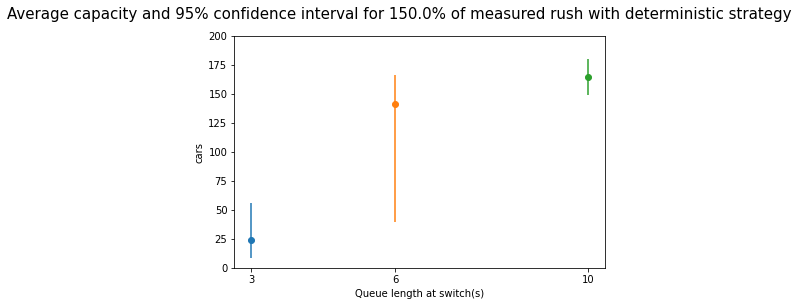

In [10]:
#plot the queue length data per strategy

#loop one time for each arrival rate
for i in range(3):

  fig, ax = plt.subplots(nrows = 1, ncols = 1)#create 1 subplits

  for j in range(3): #loop through each switch strategy

    #plot the error bars for each quantity
    ax.errorbar(switch_len[j], summary_capacity_data[i,j][0], fmt='-o',
                   yerr = [[summary_capacity_data[i,j][0]-summary_capacity_data[i,j][1]], [summary_capacity_data[i,j][2]-summary_capacity_data[i,j][0]]])
  #set the x ticks
  plt.setp(ax, xticks=switch_len)

  #set labels
  ax.set_xlabel("Queue length at switch(s)")
  ax.set_ylim([0,np.max(summary_capacity_data[i])+20])
  ax.set_ylabel("cars")

  #set labels

  #the layout
  fig.tight_layout()

  #titles
  fig.suptitle(f"Average capacity and 95% confidence interval for {100*densities[i]}% of measured rush with deterministic strategy", 
                 fontsize=15, verticalalignment = "top", y = 1.05)
